In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages


In [2]:
from os import environ
from sqlalchemy import create_engine

%load_ext dotenv
%dotenv

POSTGRES_ADDRESS = environ['DB_HOST']
POSTGRES_PORT = environ['DB_PORT']
POSTGRES_USERNAME = environ['DB_USER']
POSTGRES_PASSWORD = environ['DB_PASSWORD']
POSTGRES_DBNAME = environ['DB_NAME']

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME,
                        password=POSTGRES_PASSWORD,
                        ipaddress=POSTGRES_ADDRESS,
                        port=POSTGRES_PORT,
                        dbname=POSTGRES_DBNAME))

connection = create_engine(postgres_str)


In [3]:
checkins = pd.read_sql_query(
    '''SELECT * FROM checkins;''',
    connection,
)

reservations = pd.read_sql_query(
    '''SELECT * FROM reservations;''',
    connection,
)

users = pd.read_sql_query(
    '''SELECT * FROM users WHERE role = 'user' ;''',
    connection,
)


In [4]:
reservations_x_checkin = pd.merge(
    reservations,
    checkins,
    how='inner',
    left_on=['user_id', 'reservation_date'],
    right_on=['user_id', 'checkin_date'],
)


In [5]:
def get_frequency(user):
    reservations_made = reservations['user_id'][reservations['user_id'] == user.id].count(
    )
    reservations_with_checkins = reservations_x_checkin['user_id'][reservations_x_checkin['user_id'] == user.id].count(
    )

    return round((reservations_with_checkins / reservations_made) * 100, 2)


users['frequency'] = users.apply(lambda row: get_frequency(row), axis=1)


In [ ]:
output_users = users[['first_name', 'last_name',
                      'email', 'frequency']][users['frequency']!=100].sort_values('frequency', ascending=False)

figure, ax = plt.subplots(figsize=(12, 12))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=output_users.values,
                 colLabels=output_users.columns, loc='center')

pp = PdfPages("output.pdf")
pp.savefig(figure, bbox_inches='tight')
pp.close()


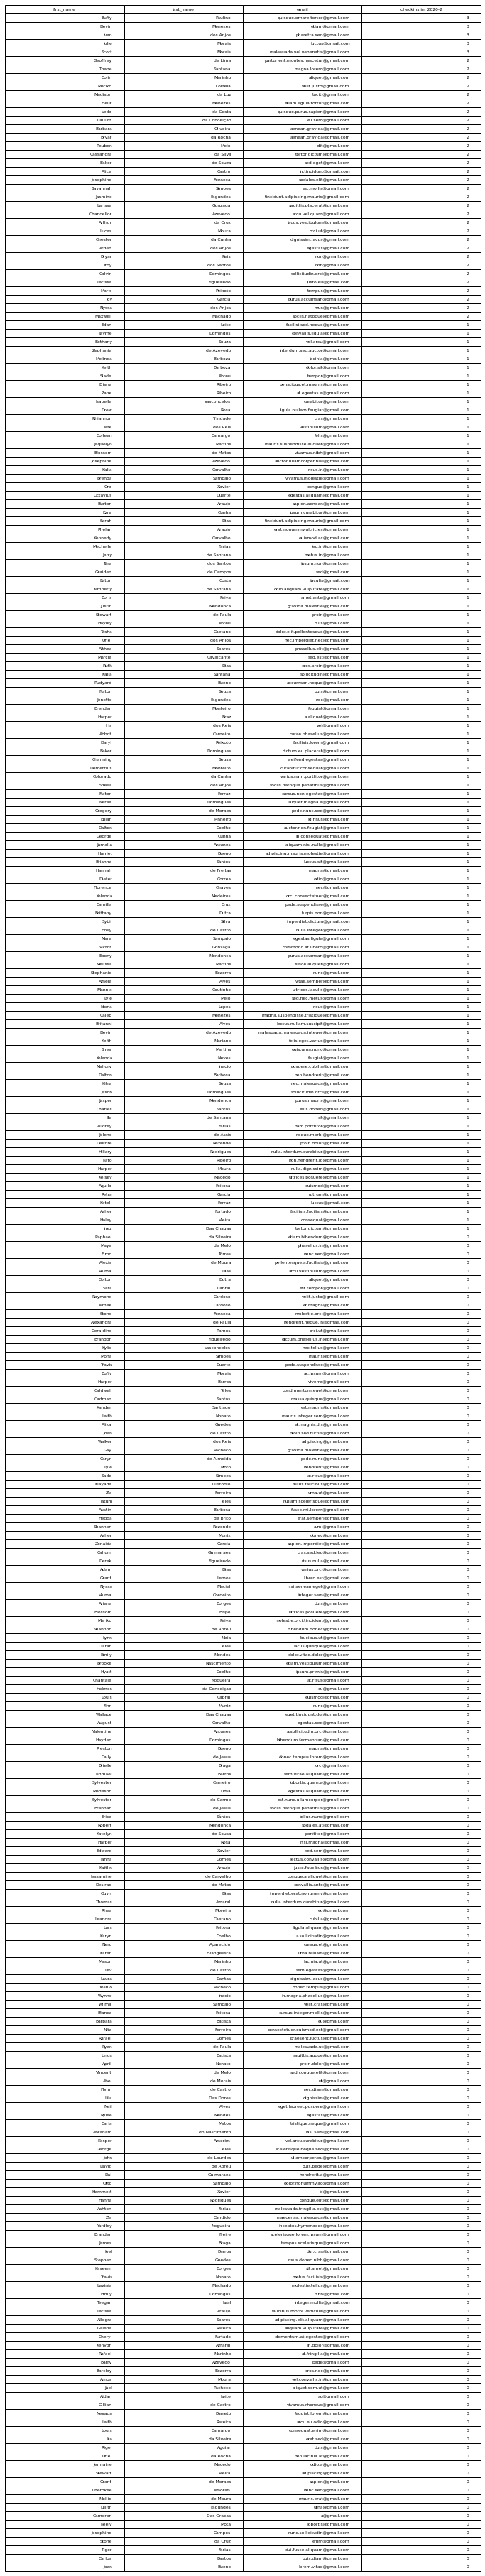

In [12]:
MONTH_TO_CHECK = 2
YEAR_TO_CHECK = 2020

dataframe_key = f'checkins in: {YEAR_TO_CHECK}-{MONTH_TO_CHECK}'


def count_user_checkins_by_mont(user, month, year):
    return checkins['user_id'][
        (checkins['user_id'] == user.id)
        & (checkins['timestamp'].dt.month == month)
        & (checkins['timestamp'].dt.year == year)
    ].count()


users[dataframe_key] = users.apply(
    lambda row: count_user_checkins_by_mont(row, MONTH_TO_CHECK, YEAR_TO_CHECK), axis=1)

output_users = users[['first_name', 'last_name', 'email',
                      dataframe_key]].sort_values(dataframe_key, ascending=False)

figure, ax = plt.subplots(figsize=(12, 12))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=output_users.values,
                 colLabels=output_users.columns, loc='center')

pp = PdfPages("output-months.pdf")
pp.savefig(figure, bbox_inches='tight')
pp.close()


In [ ]:
from datetime import date

results = {}

DATES_TO_CHECK = [
    date(2021, 7, 18),
    date(2021, 2, 12),
    date(2021, 9, 1),
    date(2021, 9, 20),
]


def get_users_present_by_day(checkin_date):
    return checkins[checkins['checkin_date'] == checkin_date]['user_id'].tolist()


for date in DATES_TO_CHECK:
    user_ids = get_users_present_by_day(date)
    user_info = users[users['id'].isin(
        user_ids)][['first_name', 'last_name', 'email']].values.tolist()
    formated_user_info = [
        f'{first_name} {last_name} - {email}' for first_name, last_name, email in user_info]
    print(f'{date} - {" | ".join(formated_user_info)}')
